> Fundação Getúlio Vargas - RJ <br>
> Escola de Matemática Aplicada (EMAp) <br>
> Graduação em Ciência de Dados e Inteligência Artificial <br>
> Alunos: Gianlucca Devigili e Maisa de O. Fraiz <br>
# Projetos em Ciência de Dados - A2

## 1. Introdução

Esse trabalho tem como intuito melhorar os resultados obtidos na A1 da matéria de Projetos em Ciência de Dados, e, para isso, decidimos seguir a abordagem de otimizar os modelos já utilizados, ao invés de seguir testando novos.

O primeiro passo pós-A1 foi a refatoração dos códigos, de modo a organizar e padronizar os notebooks, além de reorganizar o repositório. A estrutura atual do repositório é:

```
src/
├── data/
|   ├── processed-data/
|   |   └── arquivos .pkl com os dados processados e prontos para serem usados nos modelos
|   |   raw-data/
|   |   └── arquivos .csv baixados do kaggle e o arquivo train.pkl que é a versão pickle do arquivo train.csv
├── data-engineering/
|   ├── pre-process-data.ipynb
|   └── transform-data.ipynb
├── EDA/
|   └── EDA.ipynb
├── models/
|   ├── old_notebooks
|   |   └── arquivos antigos usados na A1
|   ├── chain-models.ipynb
|   ├── data-preparation.py
|   ├── metrics.ipynb
|   ├── models.py
|   ├── multitask-models.py
└── └── template.ipynb
```

Contendo agora um pipeline de execução melhor definido, sendo necessária a execução do arquivo `pre-process-data.ipynb` para carregar os dados, renomear colunas e criar id's. Também realizamos ajustes pontuais na tipagem de colunas de datas. 

Após isso, deve ser feita a execução do arquivo `transform-data.ipynb`, que realiza as devidas transformações nos dados, como criação de novas features, otimização de memória (a ser descrita abaixo) e o processo de _JOIN_ dos diversos datasets em um só. Esse arquivo gera os .pkl (pickle) dos subconjuntos de dados, bem como o arquivo principal chamado `train.pkl`, fazendo com que tenhamos um dataset prontamente tratado para ser executado nos arquivos de modelos do diretório `models/`. 

Tal refatoração e separação de arquivos foi feita de modo a garantir que os dados utilizados pelos membros da dupla sempre estivessem na mesma versão e não houvessem problemas gerados por conta de diferenças nos datasets, algo que acabamos enfrentando no decorrer da A1.

O principal avanço em termos de resultados obtivemos ao começar a treinar os modelos utilizando o [sklearn.multioutput.MultiOutputRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html). Obtivemos melhores resultados especialmente no modelo de Gradient Boosting (sklearn) que tinha uma MAE de 1.216814, e teve seu erro reduzido para 0.797927. Além disso, o seu tempo de execução diminuído em quase 1h.

Por último, foram adicionados mais dados e então realizada a seleção das novas features conforme sua importância, assim conseguindo obter MAEs menores, com a menor sendo a de 0.703 do Gradient Boosting.

O notebook aqui apresentado une esses processos em um só arquivo, e, sendo assim, não é necessário acesso ao repositório completo para a execução.

## Instruções de Execução

**IMPORTANTE:**

> As versões das bibliotecas utilizadas se encontram no arquivo [`requirements.txt`](https://github.com/GDevigili/player-digital-engagement-forecasting/blob/main/requirements.txt). Versões mais recentes das bibliotecas podem gerar erros no código devido a funções e métodos que foram deprecados em atualizações que ocorreram no decorrer deste semestre.

In [32]:
# Variáveis de configuração

# Variável que define se o dataset será carregado de um .csv ou de um .pkl
# Se você nunca tiver rodado esse notebook e não possuir os arquivos em .pkl, é necessário atualizar a variável para TRUE
load_from_csv = False

# Caminho para o dataset
raw_data_path = '../data/raw-data/'
dataset_path = raw_data_path + 'train_updated.csv'

# Caminho onde serão salvos os dados processados
processed_data_path = '../data/processed-data/'
processed_dataset_path = processed_data_path + 'train.pkl' 

# Variável que define se o dataset será processado ou se será carregado de um .pkl

# Se você já rodou o arquivo alguma vez e já possui o train.pkl atualizado e tratado,
# alterar a variável para FALSE reduzirá o tempo de execução do notebook

prepare_data = True

# Varíavel que define se será realizado o feature selection ou vai carregar de um .pkl

# Se você já possui o arquivo features.pkl, é recomendado manter essa variável como FALSE,
# pois o feature_selection é realizado com Gradient Boosting

feature_selection = False

## Setup Inicial

**IMPORTANTE:**

As funções que foram criada para o trabalho estão no arquivo functions.py, que é importado aqui. Esse arquivo será disponibilizado junto com a entrega do trabalho.

In [2]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np

import pickle as pkl

from joblib import Parallel, delayed

from pandas.api.types import is_datetime64_any_dtype as is_datetime

from functions import *

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.multioutput import MultiOutputRegressor


# disable warnings
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
# variáveis globais

PROCESSED_DATA_PATH = '../data/processed-data/'
MODEL_PATH = '../models/trained-models/'

TARGET_COLS = ['target1', 'target2', 'target3', 'target4']

RANDOM_SEED = 42

TEST_SPLIT_DATE = '2021-04-30'

## 2. Funções auxiliares

De modo a manter o notebook mais limpo, optamos por mover as funções aqui utilizadas no arquivo `functions.py`. No arquivo estão as funções:
+ `unpack_json` e `unpack_data`: funções provenientes do notebook getting started para o tratamento inicial dos dados.
+ `create_id`: função que cria um id baseado na coluna de data e mais uma coluna a ser escolhida de modo a facilitar a operação de _JOIN_ dos diferentes subconjuntos de dados. Os ids utilizados foram `IdDtPlayer`, `IdDtTeam` e `IdDtGame`.
+ `reduce_mem_usage`: função que modifica o data type das colunas do dataframe para reduzir o uso de memória.
+ `sort_df`: organiza (sort) o dataframe com base no argumento.
+ `shift_targets`: realiza o shift dos targets.
+ `train_test_split`: realiza a divisão do dataset em train, test e validation.
+ `x_y_split`: realiza a divisão do dataset em dois sets x e y.
+ `naive`: modelo naive utilizando shift 1.
+ `MeanModel`: modelo mean.
+ `evaluate_mae`: calcula o MAE para cada target, além da média dos MAE.
+ `MAE`: define o MAE (função utilizada para calcular a métrica AMAE).
+ `AMAE`: calcula a métrica AMAE (explicada na seção "métricas" do trabalho) dado y_pred e y_obs.
+ `evaluate_amae`: calcula o AMAE para cada target, além da média dos AMAE.
+ `fit_predict_targets`: realiza o fit do modelo e a predição dos targets.

## 3. Carga e Tratamento de Dados

O principal problema tratado nesta parte do trabalho foi o grande volume dos dados, que dificultava a execução do trabalho por questões computacionais como limitação de RAM e processamento, além de atrasar o desenvolvimento do mesmo. 

A redução foi feita transformando as tipagens dos dados em tipos mais simples, por exemplo salvando as variáveis float64 em variáveis float16. Tal redução conseguiu ao todo diminuir o dataset total de 2134.42 MB para 960.62 MB, redução de 55.0%.

Além disso, foram adicionados dois novos datasets ao conjunto de treino, aumentando a quantidade de features, estes sendo os datasets de _Team Box Scores_ e _Games_. As colunas foram selecionadas manualmente e renomeadas seguindo os padrões pré-definidos pela equipe.

Foram também criadas features de _lag_ para todos os targets, considerando _lags_ de até 7 dias. A escolha do número foi por conta de que a partir deste ponto os valores começaram a ser pouco significativos e a piorar a performance do modelo. Além disso foi decomposta a feature de data em diversos outros pontos, como dia, mês, ano, dia do ano, dia da semana e assim por diante.

Parte do tratamento também consistiu em transformar todas as features de Cd e Flg (as features que envolviam algum código, como tipo de jogo ou período do dia, e features de flag, que indicavam algum valor booleano) em _dummies_. Assim, features categóricas com _N_ distintas categorias viraram _N_ features booleanas distintas, indicando a presença ou não daquele valor. Em casos de NaN, todos as features dummies eram zeradas. Esta modificação foi realizada de modo a conseguir considerar tais valores em modelos lineares que não suportam valores categóricos.

Outro ponto importante do tratamento dos dados foi a definição de regra para tratamento de valores nulos com a substituição dos mesmos por 0. A ocorrência de valores nulos era baixa na maioria das colunas, porém aumentava drasticamente após a junção de datasets - vez que dados de Box Scores se referem aos dados dos dias em que existem jogos. Acreditamos ser plausível colocar os dados como sendo 0, fazendo com que em dias sem jogos, jogadores/equipes tivessem um número 0 de "vitórias", "home runs" e afins.

Ao final, o dataset ficou com 195 colunas.

In [4]:
# dataframes
dataset_names = {
    'Awards': 'awards.csv', 
    'Example': 'example_test.csv', 
    'Players': 'players.csv',
    'Seasons': 'seasons.csv', 
    'Teams': 'teams.csv', 
    'Train': 'train_updated.csv'
}
for key in dataset_names:
    dataset_names[key] = raw_data_path + dataset_names[key]

### Carregando o dataset de treino

In [5]:
%%time
if load_from_csv:
    df_train = pd.read_csv(dataset_names['Train'])
    pd.to_pickle(df_train, raw_data_path + 'train.pkl')
else:
    df_train = pd.read_pickle(raw_data_path + 'train.pkl')

CPU times: total: 2.23 s
Wall time: 7.72 s


#### Targets

In [6]:
%%time
if prepare_data:

    # criação do dataset de targets

    # unpack the data
    Y = unpack_data(df_train, dfs = ['nextDayPlayerEngagement'])['nextDayPlayerEngagement']

    # change datatypes
    Y = Y.astype({name: np.float32 for name in ["target1", "target2", "target3", "target4"]})

    # match target dates to feature dates and create date index
    Y = Y.rename(columns={'engagementMetricsDate': 'date'})

    # change datatypes
    Y['date'] = pd.to_datetime(Y['date'])

    # reset index
    Y = Y.set_index('date').to_period('D')
    Y.index = Y.index - 1
    Y = Y.reset_index()

    # rename and select columns
    cols_Y = {
        'date': 'Dt',
        'playerId': 'IdPlayer',
        'target1': 'target1',
        'target2': 'target2',
        'target3': 'target3',
        'target4': 'target4'
    }
    Y = Y[list(cols_Y)]
    Y.columns = list(cols_Y.values())
    Y['Dt'] = Y['Dt'].astype('datetime64[ns]')
    Y = create_id(Y, ['Dt', 'IdPlayer'], 'Player')

    pd.to_pickle(Y, processed_data_path + 'targets.pkl')

    del Y

CPU times: total: 0 ns
Wall time: 0 ns


#### PlayerBoxScores

In [7]:
%%time
if prepare_data:
    # load the data
    df_playerBoxScores = unpack_data(df_train, dfs = ['playerBoxScores'])['playerBoxScores']

    # Cria o dataset de jogos
    cols = {
        # columns related to other dimensions
        'gamePk': 'IdGame',
        'gameDate': 'DtGame',
        'gameTimeUTC': 'DtGameUTC',
        'playerId': 'IdPlayer',
        'teamId': 'IdTeam',
        'jerseyNum': 'NuJersey',
        'positionCode': 'CdPosition',
        # suggested column
        'strikeOutsPitching': 'NuStrikeOutsPitching',
    }  
    # numeric columns
    for numeric_col in list(df_playerBoxScores.columns[12:]):
        # skip the columns that contains data about pitching due the amount of Nan values
        if 'Pitching' not in numeric_col:
            cols[numeric_col] = 'Nu' + numeric_col[0].upper() + numeric_col[1:] + '_Player'

    df_playerBoxScores = df_playerBoxScores[list(cols)]
    df_playerBoxScores.columns = list(cols.values())

    # df_playerBoxScores['DtGame'] = df_playerBoxScores['DtGame'] + " 00:00:00"
    df_playerBoxScores['DtGame'] = df_playerBoxScores['DtGame'].astype('datetime64[ns]')
    df_playerBoxScores['DtGameUTC'] = df_playerBoxScores['DtGameUTC'].astype('datetime64[ns]')
    df_playerBoxScores = create_id(df_playerBoxScores, ['DtGame', 'IdPlayer'], 'Player')
    df_playerBoxScores = create_id(df_playerBoxScores, ['DtGame', 'IdTeam'], 'Team')
    df_playerBoxScores = create_id(df_playerBoxScores, ['DtGame', 'IdGame'], 'Game')

    # Salva o dataset
    pd.to_pickle(df_playerBoxScores, processed_data_path + 'playerBoxScores.pkl')

    del df_playerBoxScores

CPU times: total: 0 ns
Wall time: 0 ns


#### Team Box Scores

In [8]:
%%time
if prepare_data:
    df_tbs = unpack_data(df_train, dfs = ['teamBoxScores'])['teamBoxScores']

    cols = {
        'gameDate': 'DtGame',
        'teamId': 'IdTeam',
        'home': 'FlgHome',
        'gamePk': 'IdGame',
    }

    for numeric_col in list(df_tbs.columns[4:]):
        cols[numeric_col] = 'Nu' + numeric_col[0].upper() + numeric_col[1:] + '_Team'

    df_tbs = df_tbs[list(cols)]
    df_tbs.columns = list(cols.values())

    df_tbs['DtGame'] = df_tbs['DtGame'].astype('datetime64[ns]')
    df_tbs = create_id(df_tbs, ['DtGame', 'IdTeam'], 'Team')
    df_tbs = create_id(df_tbs, ['DtGame', 'IdGame'], 'Game')
    df_tbs['FlgHome'] = df_tbs['FlgHome'].astype('bool')

    pd.to_pickle(df_tbs, processed_data_path + 'teamBoxScores.pkl')

    del df_tbs

CPU times: total: 0 ns
Wall time: 0 ns


#### Games

In [9]:
%%time
if prepare_data:
    df_games = unpack_data(df_train, dfs = ['games'])['games']

    cols = {
        'gamePk': 'IdGame',
        'gameType': 'CdGameType',
        'season': 'NuSeason',
        'gameDate': 'DtGame',
        'codedGameState': 'CdGameState',
        'detailedGameState': 'CdGameState',
        'isTie': 'FlgTie',
        'gameNumber': 'NuGame',
        'doubleHeader': 'CdDoubleHeader',
        'dayNight': 'CdDayNight',
        'scheduledInnings': 'NuScheduledInnings',
        'gamesInSeries': 'NuGamesInSeries',
        'homeId': 'IdHomeTeam',
        'homeWins': 'NuWinsHomeTeam',
        'homeLosses': 'NuLossesHomeTeam',
        'homeWinPct': 'NuWinPctHomeTeam',
        'homeWinner': 'FlgWinnerHomeTeam',
        'homeScore': 'NuScoreHomeTeam',
        'awayId': 'IdAwayTeam',
        'awayWins': 'NuWinsAwayTeam',
        'awayLosses': 'NuLossesAwayTeam',
        'awayWinPct': 'NuWinPctAwayTeam',
        'awayWinner': 'FlgWinnerAwayTeam',
        'awayScore': 'NuScoreAwayTeam',
    }

    df_games = df_games[list(cols)]
    df_games.columns = list(cols.values())

    df_games['DtGame'] = df_games['DtGame'].astype('datetime64[ns]')
    df_games = create_id(df_games, ['DtGame', 'IdGame'], 'Game')

    pd.to_pickle(df_games, processed_data_path + 'games.pkl')

    del df_games

CPU times: total: 0 ns
Wall time: 0 ns


### Tratamento dos dados

#### Carregando os dados

In [10]:
%%time
if prepare_data:
    df_targets = pd.read_pickle(processed_data_path + 'targets.pkl')
    df_pbs = pd.read_pickle(processed_data_path + 'playerBoxScores.pkl')
    df_tbs = pd.read_pickle(processed_data_path + 'teamBoxScores.pkl')
    df_g = pd.read_pickle(processed_data_path + 'games.pkl')

CPU times: total: 0 ns
Wall time: 0 ns


#### Reduzindo memória

In [11]:
%%time
if prepare_data:
    df_pbs = reduce_mem_usage(df_pbs);
    df_tbs = reduce_mem_usage(df_tbs);

CPU times: total: 0 ns
Wall time: 0 ns


#### Shifting

In [12]:
%%time
if prepare_data:
    sort_df(df_targets)
    df_train = shift_targets(df_targets, shift_vals=[1, 2, 3, 4, 5, 6, 7])

CPU times: total: 0 ns
Wall time: 0 ns


#### Features de Datetime

In [13]:
%%time
if prepare_data:
    # Transform the datetime col into new features
    df_train['DtYear'] = df_train['Dt'].dt.year
    df_train['DtMonth'] = df_train['Dt'].dt.month
    df_train['DtDay'] = df_train['Dt'].dt.day
    df_train['DtDayOfWeek'] = df_train['Dt'].dt.dayofweek
    df_train['DtDayOfYear'] = df_train['Dt'].dt.dayofyear
    df_train['DtQuarter'] = df_train['Dt'].dt.quarter
    # get the hour and minute from the PBS
    df_pbs['DtHour'] = df_pbs['DtGameUTC'].dt.hour
    df_pbs['DtMinute'] = df_pbs['DtGameUTC'].dt.minute
    df_pbs['DtHour'][df_pbs['DtHour'] == 0] = 24

CPU times: total: 0 ns
Wall time: 0 ns


### Unindo os datasets

#### Player Box Scores

In [14]:
%%time
if prepare_data:
    df_train = pd.merge(df_train, df_pbs, on=['IdDtPlayer'], how='left')

# Substitui os valores Nan das seguintes colunas por 0
    f = [c for c in df_train.columns if c not in ['IdGame', 'DtGame', 'DtGameUTC',
    'IdPlayer_y','IdTeam','NuJersey','CdPosition', 'target1_shift_1', 'target2_shift_1',
    'target3_shift_1','target1_shift_2', 'target3_shift_2', 'target4_shift_2',
    'target1_shift_3','target2_shift_3','target3_shift_3','target4_shift_3',
    'target1_shift_4','target2_shift_4','target3_shift_4','target4_shift_4',
    'target1_shift_5','target2_shift_5','target3_shift_5','target4_shift_5',
    'target1_shift_6','target2_shift_6','target3_shift_6','target4_shift_6',
    'target1_shift_7','target2_shift_7','target3_shift_7','target4_shift_7']]

    df_train[f] = df_train[f].fillna(0)        

    # Remove os na das seguintes colunas
    df_train = df_train.dropna(subset=[             
        'target1_shift_1', 'target2_shift_1', 'target3_shift_1', 'target1_shift_2',
        'target3_shift_2', 'target4_shift_2', 'target1_shift_3', 'target2_shift_3',
        'target3_shift_3', 'target4_shift_3', 'target1_shift_4', 'target2_shift_4',
        'target3_shift_4', 'target4_shift_4', 'target1_shift_5', 'target3_shift_5',
        'target4_shift_5', 'target1_shift_6', 'target2_shift_6', 'target3_shift_6',
        'target4_shift_6', 'target1_shift_7', 'target2_shift_7', 'target3_shift_7',
        'target4_shift_7'])

    df_train.rename(columns={'IdPlayer_x': 'IdPlayer'}, inplace=True)

CPU times: total: 0 ns
Wall time: 0 ns


#### Team Box Scores

In [15]:
%%time
if prepare_data:
    df_train = pd.merge(df_train, df_tbs, on = ['IdDtTeam'], how = 'left')

    # Substitui os valores Nan das seguintes colunas por 0
    f = [
        'FlgHome','NuFlyOuts_Team', 'NuGroundOuts_Team', 'NuRunsScored_Team',
        'NuDoubles_Team', 'NuTriples_Team', 'NuHomeRuns_Team', 'NuStrikeOuts_Team',
        'NuBaseOnBalls_Team', 'NuIntentionalWalks_Team', 'NuHits_Team', 'NuHitByPitch_Team',
        'NuAtBats_Team', 'NuCaughtStealing_Team', 'NuStolenBases_Team', 'NuGroundIntoDoublePlay_Team',
        'NuGroundIntoTriplePlay_Team', 'NuPlateAppearances_Team', 'NuTotalBases_Team', 'NuRbi_Team',
        'NuLeftOnBase_Team', 'NuSacBunts_Team', 'NuSacFlies_Team', 'NuCatchersInterference_Team',
        'NuPickoffs_Team', 'NuAirOutsPitching_Team', 'NuGroundOutsPitching_Team', 'NuRunsPitching_Team',
        'NuDoublesPitching_Team', 'NuTriplesPitching_Team', 'NuHomeRunsPitching_Team',
        'NuStrikeOutsPitching_Team', 'NuBaseOnBallsPitching_Team', 'NuIntentionalWalksPitching_Team',
        'NuHitsPitching_Team', 'NuHitByPitchPitching_Team', 'NuAtBatsPitching_Team',
        'NuCaughtStealingPitching_Team', 'NuStolenBasesPitching_Team', 'NuInningsPitched_Team',
        'NuEarnedRuns_Team', 'NuBattersFaced_Team', 'NuOutsPitching_Team', 'NuHitBatsmen_Team',
        'NuBalks_Team', 'NuWildPitches_Team', 'NuPickoffsPitching_Team', 'NuRbiPitching_Team',
        'NuInheritedRunners_Team', 'NuInheritedRunnersScored_Team', 'NuCatchersInterferencePitching_Team',
        'NuSacBuntsPitching_Team', 'NuSacFliesPitching_Team'
    ]

    df_train[f] = df_train[f].fillna(0)        

    df_train = df_train.rename(columns={'IdDtGame_y': 'IdDtGame'})

CPU times: total: 0 ns
Wall time: 0 ns


#### Games

In [16]:
%%time
if prepare_data:
    df_train = pd.merge(df_train, df_g, on = ['IdDtGame'], how = 'left')

    f = [
        'NuSeason', 'NuGame',
        'NuScheduledInnings', 'NuGamesInSeries', 'NuWinsHomeTeam',
        'NuLossesHomeTeam', 'NuWinPctHomeTeam', 'NuScoreHomeTeam',
        'NuWinsAwayTeam', 'NuLossesAwayTeam', 'NuWinPctAwayTeam', 'NuScoreAwayTeam'
    ]
    df_train[f] = df_train[f].fillna(0)        

    df_train = pd.get_dummies(df_train, columns = ['CdPosition', "CdGameType", "CdGameState", "CdDoubleHeader", 
                                        "CdDayNight", "FlgWinnerHomeTeam", "FlgWinnerAwayTeam",'FlgTie', 'FlgHome'])

CPU times: total: 0 ns
Wall time: 0 ns


### Drop colunas

In [17]:
%%time
if prepare_data:
    df_train.drop([
    'IdGame_x', 'DtGame_x', 'DtGameUTC', 'IdPlayer_y',
    'IdTeam_x', 'IdTeam_y', "NuGameTimeUTC_Team", "IdDtGame", "DtGame", "IdGame",
    'IdGame_y', 'NuJersey', "DtGame_y", "IdHomeTeam", "IdAwayTeam", "IdDtPlayer",
    "IdDtTeam", "IdDtGame_x"], axis = 1, inplace = True)

CPU times: total: 0 ns
Wall time: 0 ns


### Salvando datasets

In [18]:
%%time
if prepare_data:
    df_train_reduced = reduce_mem_usage(df_train[df_train.columns.difference(['target1', 'target2', 'target3', 'target4'])]) 
    df_train_reduced[TARGET_COLS]= df_train[TARGET_COLS]

    df_train = df_train_reduced.copy()

    del df_train_reduced

    df_targets.to_pickle(processed_data_path + 'targets.pkl')
    df_pbs.to_pickle(processed_data_path + 'playerBoxScores.pkl')
    df_tbs.to_pickle(processed_data_path + 'teamBoxScores.pkl')
    df_g.to_pickle(processed_data_path + 'games.pkl')

    df_train.to_pickle(processed_data_path + 'train.pkl')
    
    del df_train, df_pbs, df_tbs, df_g, df_targets

CPU times: total: 0 ns
Wall time: 0 ns


## 4. Modelos

Os modelos finais foram treinados utilizando dados de 4 subconjuntos presentes do arquivo `train.csv`:

- Targets (dados a serem previstos)
- PlayerBoxScores (dados de jogador em determinado jogo)
- TeamBoxScores (dados de equipe em determinado jogo)
- Games (pontuação de jogo e vencedores/perdedores)

O dataset atualizado contava com 195 colunas, sendo 191 de features que foram utilizadas para treinar os modelos. Após isso foi realizada a seleção de features e os modelos foram retreinados com apenas 32 colunas, apresentando melhores resultados conforme será discutido posteriormente.

### Modelagens testadas

Os modelos finais utilizados foram LASSO, Ridge, ElasticNet e GradientBoosting. Além disso foram testadas diferentes abordagens, como a programação manual de um método para treinar 4 modelos distintos, posteriormente substituída pelo Multi Output Regressor do sklearn, que inclusive apresentou melhores resultados.

Além disso foi testado o Regressor Chain do sklearn, de modo a utilizar um target previsto como feature para o próximo target, contudo, após testar as 16 possíveis permutações de sequência de previsão para os 4 targets, não houve melhora alguma ao prever os modelos em cadeia ao invés de fazê-los de forma independente, o que de fato surpreende em certo ponto á que alguns _lags_ acabaram sendo features relevantes para a previsão de  outros targets.

Dentre os modelos testados pela dupla e posteriormente descartados estão _Random Forest_, que demorou mais de 8 horas para rodar e portanto foi considerado inadequado pela equipe por questões de eficiência computacional, _Multitask LASSO_, que teve seu desempenho superado pelo Multi Output Regressor utilizando o modelo LASSO e o modelo de _Decision Tree_, que apresentava um erro maior que os modelos lineares e um tempo de treinamento consideravelmente alto (aproximadamente 45 minutos) para que continuássemos utilizando ele para comparação de resultados. Vale ressaltar que tentamos melhorar os modelos já testados ao invés de ficarmos testando mais modelos novos já que sabíamos, através de outros grupos, que era possível obter resultados melhores com estes.

Chegamos a estudar a possibilidade de utilizar redes neurais mas acabamos por não incluí-las no trabalho final por não termos desenvolvido tanto neste âmbito em detrimento de melhorar os modelos já existentes.

### Métricas alternativas

Para a A1, mencionamos que o MAE provavelmente não era a melhor métrica a ser utilizada para nossos dados, mas não apresentamos uma alternativa. Para esse trabalho, então, decidimos testar as seguintes métricas alternativas:

+ `R2`: testamos essa métrica por ser independente de contexto, e ter um "range" entre 0 e 1, sendo melhor de comparar resultados.
+ `MSE (Mean Squared Error)`: sendo uma variação do MAE, testamos pela sua sensibilidade a outliers.
+ `MSLE (Mean Squared Log Error)`: testamos essa métrica pois ela penaliza subestimar o target mais do que superestimá-lo, e queríamos ver como esse comportamento modificaria nossos resultados.
+ `Max`: testamos essa métrica pois ela retorna o maior erro que o modelo realizou. Apesar de ser interessante descobrir qual modelo tem o menor erro máximo, ela não retorna uma estimativa de qualidade geral do modelo, e sendo assim não é muito útil.
+ `AMAE`: métrica proposta pelo Grupo 1, ela funciona da seguinte maneira: para cara limite $\alpha_i$ entre 0 e 100 em uma coleção finita ${\alpha_1, ..., \alpha_n}$, é computado o MAE $m_i$ para amostras com engajamento maior que ou igual a $\alpha_i$ para algum dos quatro targets. Com o conjunto de pares $(alpha_i, m_i)$, calculamos uma curva no plano por interpolação linear - o AMAE é a área sob essa curva. O resultado obtido é inversamente proporcional à efetividade do modelo em prever diferentes níveis de popularidade.

Como métrica final para o nosso trabalho, escolhemos a AMAE, pois acreditamos que ela é a mais adaptada para o que acreditamos ser o objetivo de nossos modelos (prever diferentes níveis de popularidade). Mesmo assim, em nossa tabela final, também manteremos o cálculo do MAE, de forma a poder comparar nossos resultados com os obtidos na A1.

### Feature Selection

A primeira tentativa de feature selection na A1 foi utilizando o modelo MultitaskLASSO, porém não obtivemos melhora nos resultados após a seleção feita e a MAE se manteve superior à 1.2. Para a A2, a metodologia para a seleção das features utilizadas foi a escolha de todas as features dos quatro modelos de Gradient Boosting treinados pelo MultiOutputRegressor que apresentassem uma importância maior que 0.5%, resultando num total de 32 features. Dessas, a maioria foram os lags dos targets e as restantes selecionadas foram CdDayNight_night, CdPosition_1.0, Dt, DtDayOfYear, NuHomeRuns_Player, NuInningsPitched_Player, NuRbi_Player, NuTotalBases_Player. 

A conclusão que pode ser tirada com isso é que o período do dia, homeruns e inning pitches são as jogadas mais "importantes" para os target, além do número de Bases que o jogador fez e o índice "Runs Batted In" (RBI), que indica a contribuição do jogador para marcar as bases. O único dado referente ao jogo que foi selecionado é se o mesmo é de noite, além de uma grande contribuição de se o jogador joga na posição de Pitcher. 

Além disso, a variável Dt (data) foi obviamente uma das mais importantes, por se tratar de uma série temporal. A decomposição de dia do ano foi relevante ao mostrar que a época do ano influencia no resultado final (provavelmente finais de temporada e períodos que não coincidem com momentos decisivos de outros esportes). Uma coisa interessante de se ressaltar é que alguns lags foram selecionados como features importantes para a previsão de outros targets (por exemplo o lag 1 do target 2 influenciando no target 4).

Após selecionadas apenas as features mais importantes de acordo com o critério acima, os modelos foram rodados novamente agora com o dataset reduzido. Tal redução foi capaz de fazer com que o erro do GradientBoosting fosse de 1.0 para 0.7.

### Carrega os Dados

In [19]:
df_train = pd.read_pickle(processed_dataset_path)

### Preparação e Feature Selection

In [20]:
if feature_selection:
    
    df_train = df_train.drop(columns = ['IdPlayer'])

    train, test, val = train_test_split(df_train)

    train['Dt'] = pd.to_numeric(pd.to_datetime(train['Dt']))
    test['Dt']= pd.to_numeric(pd.to_datetime(test['Dt']))
    val['Dt'] = pd.to_numeric(pd.to_datetime(val['Dt']))

    # defines the model and create the multioutput regressor
    model = GradientBoostingRegressor(random_state=RANDOM_SEED, loss = 'absolute_error')
    model_name = 'GradientBoostingRegressor | MultiOutput'
    regressor = MultiOutputRegressor(model, n_jobs=-1)

    # fit the model
    regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

    # make predictions
    y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

    for i in range(len(TARGET_COLS)):
        plt.bar(range(len(regressor.estimators_[i].feature_importances_)), regressor.estimators_[i].feature_importances_)
        plt.show()
        for i in range(len(TARGET_COLS)):
            plt.bar(range(len(regressor.estimators_[i].feature_importances_)), regressor.estimators_[i].feature_importances_)

    selected_features = pd.array([])
    for i in range(len(TARGET_COLS)):
        features = np.where(regressor.estimators_[i].feature_importances_ >= 0.005)
        selected_features = np.append(selected_features, train.drop(columns=TARGET_COLS).columns[features])
        selected_features.extend(list(np.where(regressor.estimators_[i].feature_importances_ > 0.0001)))
    np.where(regressor.estimators_[0].feature_importances_ > 0.0)
    len(np.unique(selected_features))

    with open('features.pkl', 'wb') as file:
         pickle.dump(selected_features, file)
    pickle.load(open('features.pkl', 'rb'))
    
else:
    with open('features.pkl', 'rb') as f:
        selected_features = pkl.load(f)
    df_train = df_train[np.append(np.append(TARGET_COLS, selected_features), 'IdPlayer')]

In [26]:
np.unique(selected_features)

array(['CdDayNight_night', 'CdPosition_1.0', 'Dt', 'DtDayOfYear',
       'NuHomeRuns_Player', 'NuInningsPitched_Player', 'NuRbi_Player',
       'NuTotalBases_Player', 'target1_shift_1', 'target1_shift_2',
       'target1_shift_3', 'target1_shift_4', 'target1_shift_5',
       'target2_shift_1', 'target2_shift_3', 'target2_shift_4',
       'target2_shift_5', 'target2_shift_6', 'target2_shift_7',
       'target3_shift_1', 'target3_shift_2', 'target3_shift_3',
       'target3_shift_4', 'target3_shift_5', 'target3_shift_7',
       'target4_shift_1', 'target4_shift_2', 'target4_shift_3',
       'target4_shift_4', 'target4_shift_5', 'target4_shift_6',
       'target4_shift_7'], dtype=object)

In [22]:
df_train = df_train.loc[:,~df_train.columns.duplicated()].copy()

### Train Test Split

In [42]:
train, test, val = train_test_split(df_train)

In [43]:
df_results = pd.DataFrame(columns = ['model', 'target1 | AMAE', 'target2 | AMAE', 'target3 | AMAE', 'target4 | AMAE', 'average | AMAE', 'average | MAE'])

### Baselines

In [44]:
%%time
# naive
naive = train[["target1_shift_1", "target2_shift_1", "target3_shift_1", "target4_shift_1", "IdPlayer"]].set_index('IdPlayer')
naive.rename(columns={'target1_shift_1': 'target1', 'target2_shift_1': 'target2', 'target3_shift_1': 'target3',
                     'target4_shift_1': 'target4'}, inplace=True)
# media
media = train[TARGET_COLS].mean()
media_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].mean()

# mediana
mediana = train[TARGET_COLS].median()
mediana_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].median()

summary = pd.DataFrame()
temp = pd.DataFrame()

for target in TARGET_COLS:
    
    y_true = test[target]
   
    mediapj_pred = test['IdPlayer'].map(media_por_jogador[target].to_dict())
    medianapj_pred = test['IdPlayer'].map(mediana_por_jogador[target].to_dict())
    naive_pred = test['IdPlayer'].map(naive[target].to_dict())
  
    mediana_pred = [mediana[target] for i in test.index]
    media_pred = [media[target] for i in test.index]
    

    temp.loc['Média',target]  = mean_absolute_error(y_true,media_pred)
    temp.loc['Média por Jogador',target]  = mean_absolute_error(y_true,mediapj_pred)
    temp.loc['Mediana',target]  = mean_absolute_error(y_true,mediana_pred)
    temp.loc['Mediana por Jogador',target]  = mean_absolute_error(y_true,medianapj_pred)
    temp.loc['Naive',target]  = mean_absolute_error(y_true,naive_pred)
    summary.loc['Média',target + " | AMAE"]  =  AMAE(y_true,media_pred,show = False)
    summary.loc['Média por Jogador',target + " | AMAE"]  =  AMAE(y_true,mediapj_pred,show = False)
    summary.loc['Mediana',target + " | AMAE"]  =  AMAE(y_true,mediana_pred,show = False)
    summary.loc['Mediana por Jogador',target + " | AMAE"]  =  AMAE(y_true,medianapj_pred,show = False)
    summary.loc['Naive',target + " | AMAE"]  =  AMAE(y_true,naive_pred,show = False)
    
summary['average | MAE'] = temp.mean(axis=1)
summary['average | AMAE'] = summary.mean(axis=1)

summary = summary.reset_index()
summary = summary.rename(columns = {"index": "model"})

df_results = df_results.append(summary, ignore_index = True)

CPU times: total: 1min 21s
Wall time: 2min 3s


### Modelos Lineares

In [45]:
df_train = df_train.drop(columns = ['IdPlayer'])

In [46]:
train['Dt'] = pd.to_numeric(pd.to_datetime(train['Dt']))
test['Dt']= pd.to_numeric(pd.to_datetime(test['Dt']))
val['Dt'] = pd.to_numeric(pd.to_datetime(val['Dt']))

#### LASSO

In [47]:
%%time
from sklearn.linear_model import Lasso

# defines the model and create the multioutput regressor
model = Lasso(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Lasso | MultiOutput'
regressor = MultiOutputRegressor(model, n_jobs=-1)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
result_dict = {**amae, **{f'average | MAE': mae['average | MAE']}}

# save the results
df_results = df_results.append({'model': model_name, **result_dict}, ignore_index=True)
df_results[df_results['model'] == model_name]

CPU times: total: 3.22 s
Wall time: 10min 16s


,model,target1 | AMAE,target2 | AMAE,target3 | AMAE,target4 | AMAE,average | AMAE,average | MAE
5,Lasso | MultiOutput,5067.59576,3949.374541,5768.626309,3629.895891,4603.873125,0.909959


#### Ridge

In [48]:
%%time
from sklearn.linear_model import Ridge

# defines the model and create the multioutput regressor
model = Ridge(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Ridge | MultiOutput'
regressor = MultiOutputRegressor(model, n_jobs=-1)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
result_dict = {**amae, **{f'average | MAE': mae['average | MAE']}}

# save the results
df_results = df_results.append({'model': model_name, **result_dict}, ignore_index=True)
df_results[df_results['model'] == model_name]

CPU times: total: 3.34 s
Wall time: 8.29 s


,model,target1 | AMAE,target2 | AMAE,target3 | AMAE,target4 | AMAE,average | AMAE,average | MAE
6,Ridge | MultiOutput,4895.420876,3919.150979,5695.694745,3599.351708,4527.404577,0.925028


#### ElasticNet

In [49]:
%%time
from sklearn.linear_model import ElasticNet

# defines the model and create the multioutput regressor
model = ElasticNet(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'ElasticNet | MultiOutput'
regressor = MultiOutputRegressor(model, n_jobs=-1)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
result_dict = {**amae, **{f'average | MAE': mae['average | MAE']}}

# save the results
df_results = df_results.append({'model': model_name, **result_dict}, ignore_index=True)
df_results[df_results['model'] == model_name]

CPU times: total: 3.94 s
Wall time: 7min 20s


,model,target1 | AMAE,target2 | AMAE,target3 | AMAE,target4 | AMAE,average | AMAE,average | MAE
7,ElasticNet | MultiOutput,5039.66974,3940.878062,5750.295247,3620.259616,4587.775666,0.914881


### Tree Models

#### Gradient Boosting

In [50]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# defines the model and create the multioutput regressor
model = GradientBoostingRegressor(random_state=RANDOM_SEED, loss = 'absolute_error')
model_name = 'GradientBoostingRegressor | MultiOutput'
regressor = MultiOutputRegressor(model, n_jobs=-1)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
result_dict = {**amae, **{f'average | MAE': mae['average | MAE']}}

# save the results
df_results = df_results.append({'model': model_name, **result_dict}, ignore_index=True)
df_results[df_results['model'] == model_name]

## Resultados

## 5. Resultados e Conclusões

Segue abaixo a tabela de resultados:

In [ ]:
df_results

,model,target1 | AMAE,target2 | AMAE,target3 | AMAE,target4 | AMAE,average | AMAE,average | MAE
0,Média,6844.194194,6399.400572,7122.047829,6824.235173,5438.296362,1.604042
1,Média por Jogador,6414.210091,5524.186487,6761.347046,6119.3349,4964.078976,1.316354
2,Mediana,6900.822698,6587.090997,7190.300457,6912.138701,5518.274249,1.018393
3,Mediana por Jogador,6833.982614,6005.49286,7149.275526,6419.210155,5281.781292,0.945302
4,Naive,6773.84043,6205.150573,7008.533742,6362.128265,5270.162311,1.158547
5,Lasso | MultiOutput,5067.59576,3949.374541,5768.626309,3629.895891,4603.873125,0.909959
6,Ridge | MultiOutput,4895.420876,3919.150979,5695.694745,3599.351708,4527.404577,0.925028
7,ElasticNet | MultiOutput,5039.66974,3940.878062,5750.295247,3620.259616,4587.775666,0.914881
8,GradientBoostingRegressor | MultiOutput,6181.200965,5375.246921,6602.535582,5236.409038,5848.848126,0.707736


Pela métrica AMAE, temos os seguintes modelos, em ordem de `pior` para `melhor`:

 + GradientBoostingRegressor, Mediana, Média, Mediana por Jogador, Naive, Média por Jogador, Lasso, ElasticNet e Ridge.

Pela métrica MAE, temos os seguintes modelos, em ordem de pior para melhor:

+ Média, Média por Jogador, Naive, Mediana, Mediana por Jogador, Ridge, ElasticNet, Lasso e GradientBoostingRegressor.

Podemos perceber que as duas métricas tiram conclusões diferentes dos modelos, especialmente quando estamos falando de GradientBoostingRegressor (que para AMAE, foi a pior, mas para MAE, a melhor). Mostrando assim que o Gradiet Boosting acaba por ser em média o que menos erra, porém não tão bom em prever jogadores que estejam em um grupo de popularidade mais distinto. Então dependendo do critério podemos definir dois "melhores modelos".

### Comparações com a A1

Apesar de consideramos a métrica AMAE para esse trabalho, no momento de comparar nossos resultados com a A1, é necessário utilizarmos da MAE. Segue uma imagem dos resultados obtidos anteriormente:

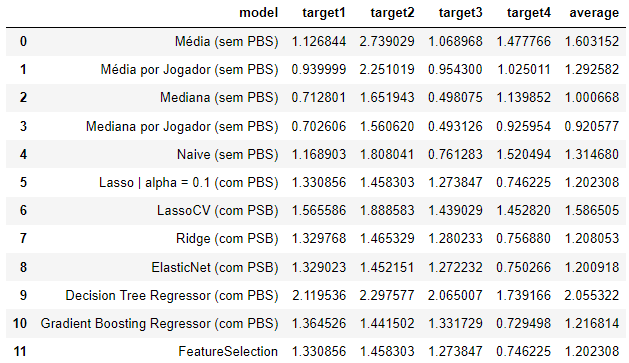

Em referência aos modelos anteriores, conseguimos atingir o objetivo de melhorar os modelos lineares e de árvore em termos de erro médio absoluto (MAE), superando as baselines. As melhoras em termos numéricos foram de:

+ `Lasso`: de 1.2 para 0.9
+ `Ridge`: de 1.2 para 0.9
+ `ElasticNet`: de 1.2 para 0.9
+ `Gradient Boosting`: de 1.2 para 0.7

Além disso, o GradientBoosting (o modelo mais pesado na A2), que anteriormente levou 2h e 48m para rodar, nesse trabalho levou apenas 58m, apenas 34% do tempo anterior.

### Conclusões finais

Os melhores modelos neste caso se mostraram Ridge e GradientBoosting, o primeiro se destacando na métrica AMAE, sendo, portanto, melhor em previsões dentro de diferentes "grupos" de popularidade, enquanto o GradientBoosting se mostrou um modelo com baixa MAE, sendo capaz de, em média, errar menos, porém falhando mais vezes ao tentar prever a popularidade de jogadores que se distinguem da média e possuem scores mais altos.

Além disso, analisando a importância das features, de fato a presença de jogadas de destaque, como homeruns e pitches, além contribuição do jogador para a pontuação da equipe, são as variáveis mais importantes para as previsões no contexto de erro médio, além de data e do dia do ano, além de, claramente, a popularidade prévia do mesmo nos dias anteriores.

Possíveis melhorias ainda no trabalho seria uma melhor seleção de hiper parâmetros através de Cross Validation ou outro teste, a adição de mais features e realizar novamente a seleção destas e distintas modelagens, como por exemplo o uso de redes neurais como outros grupos fizeram. 